In [244]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import signal
from astroquery.mast import Observations
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec


In [245]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'my diverging red blue': [(204/255, 230/255, 255/255),
                                              (0/255, 102/255, 204/255),
                                              (51/255, 0/255, 102/255),
                                              (255/255, 0/255, 102/255),
                                              (255/255, 230/255, 243/255)],
                    'my blue yellow red': [(0 / 255, 74 / 255, 171 / 255),
                                        (255 / 255, 209 / 255, 26 / 255),
                                        (178 / 255, 0 / 255, 3 / 255)],
                    'McLaren 2022': [(0/255, 38/255, 77/255),
                                    (211/255, 0/255, 87/255),
                                    (255/255, 153/255, 0/255),
                                    (191/255, 217/255, 217/255)],
                    'vibrant candy': [(0/255, 26/255, 77/255),
                                    (204/255, 0/255, 102/255),
                                    (255/255, 204/255, 0/255),
                                    (153/255, 255/255, 153/255)],
                    'ice queen': [(37/255, 0/255, 51/255),
                                  (0/255, 155/255, 153/255),
                                  (214/255, 255/255, 214/255)],
                    'ice queen2': [(0/255, 0/255, 0/255),
                                   (0/255, 134/255, 179/255),
                                   (255/255, 255/255, 200/255)],
                    'amazon queen': [(0/255, 0/255, 0/255),
                                     (25/255, 103/255, 103/255),
                                     (119/255, 179/255, 105/255),
                                     (255/255, 234/255, 0/255),
                                     (255/255, 255/255, 255/255)],
                    'amazon queen2': [(0/255, 34/255, 51/255),
                                      (25/255, 103/255, 103/255),
                                    #   (119/255, 179/255, 105/255),
                                    #   (63/255, 211/255, 146/255),
                                      (255/255, 234/255, 0/255)],
                    'colorado sunrise': [(0/255, 17/255, 51/255),
                                         (234/255, 74/255, 104/255),
                                         (255/255, 224/255, 102/255)],
                    'muted rbg': [(102/255, 0/255, 51/255),
                                  (0/255, 85/255, 128/255),
                                  (140/255, 153/255, 0/255)],
                    'perceptual rbg': [(102/255, 0/255, 51/255),
                                       (60/255, 40/255, 90/255),
                                       (0/255, 102/255, 153/255),
                                       (134/255, 179/255, 0/255),
                                       (255/255, 200/255, 50/255),
                                       (255/255, 255/255, 160/255)],
                    'mclaren livery': [(0/255, 119/255, 179/255),
                                       (204/255, 0/255, 102/255),
                                    #    (255/255, 128/255, 0/255),
                                       (255/255, 153/255, 0/255),
                                       (207/255, 226/255, 226/255)],
                    'volcanic sunrise': [(0/255, 51/255, 77/255),
                                  (153/255, 0/255, 77/255),
                                  (255/255, 80/255, 80/255),
                                  (255/255, 255/255, 153/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    'cyber grape2': [(51/255, 0/255, 51/255),
                                     (128/255, 0/255, 128/255),
                                     (255/255, 153/255, 204/255),
                                     (204/255, 255/255, 255/255)],
                    'black limeaid': [(0/255, 0/255, 77/255),
                                      (102/255, 153/255, 153/255),
                                      (204/255, 255/255, 51/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap
def unique(list_of_values):
    unique_values = []
    for _, value in enumerate(list_of_values):
        if value in unique_values:
            pass
        else:
            unique_values.append(value)
    return unique_values
def bindat(time_x, data_y, data_yerr, bin_window):
    """
    Bins timeseries data to a given time window "bintime". Units of time are in days. 
    ----------
    time_x : array_like
        Array containing time in units of days
    data_y : array_like
        Array containing data taken at each time.
    data_yerr: array_like
        Array containing uncertainties on the data
    bin_window: float
        Scalar value of the time window the data should be binned within
    
    Returns
    -------
    out_time_x: array_like
        Array containing average time for measurements within the associated bin
    out_data_y: array_like
        Array containing binned data
    out_data_yerr: array_like
        Array containing uncertaintiies on the binned data
    """

    time_x = np.array(time_x)
    data_y = np.array(data_y)
    data_yerr = np.array(data_yerr)

    bin_time = []
    bin_data = []
    num_bins = int((max(time_x) - min(time_x)) / bin_window)
    for i in range(num_bins+1):
        bin_start, bin_stop = time_x[0] + i * bin_window, time_x[0] + (i + 1) * bin_window
        temp_time = time_x[(time_x >= bin_start) & (time_x < bin_stop)]
        temp_data = data_y[(time_x >= bin_start) & (time_x < bin_stop)]
        if len(temp_time) > 0:
            bin_time.append(np.mean(temp_time))
            bin_data.append(np.mean(temp_data))
    out_time_x = np.array(bin_time)
    out_data_y = np.array(bin_data)
    out_data_yerr = np.array([])

    # print(out_time_x)
    # print(out_data_y)

    return out_time_x, out_data_y, out_data_yerr
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
def identify_period(periods, powers, fit_range=1, range_restriction=None, do_plot=False):

    if range_restriction != None:
        powers = powers[(periods >= range_restriction[0]) & (periods <= range_restriction[1])]
        periods = periods[(periods >= range_restriction[0]) & (periods <= range_restriction[1])]

    # Find the highest peak
    max_idx = np.argmax(powers)
    peak_period = periods[max_idx]

    # Define a range around the peak for fitting
    # You can adjust the range to ensure neighboring peaks don't influence the fit
    # fit_range = 0.5  # for example, 0.5 units on either side of the peak
    fit_mask = (periods > peak_period - fit_range) & (periods < peak_period + fit_range)

    # Fit the Gaussian
    popt, pcov = curve_fit(gaussian, periods[fit_mask], powers[fit_mask], p0=[powers[max_idx], peak_period, 0.1])

    fit_period = popt[1]
    fit_sigma = popt[2]

    x_fit = np.linspace(peak_period - fit_range, peak_period + fit_range, 1000)
    y_fit = gaussian(x_fit, *popt)

    if fit_period > periods[-1]:
        do_plot = True

    # Plot the results
    if do_plot == True:
        fig_test = plt.figure(figsize=(6.5, 4.5))
        ax_test = fig_test.add_subplot(111)
        ax_test.plot(periods, powers, color='black', label='Periodogram')
        ax_test.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
        ax_test.text(0.05, 0.90, '{:.2f} +/- {:.2f} d'.format(fit_period, fit_sigma), horizontalalignment='left', verticalalignment='bottom', transform=ax_test.transAxes)
        ax_test.set_xlabel('Period (d)')
        ax_test.set_ylabel('Power')
        # ax_test.set_title('Gaussian Fit to the Highest Peak in Periodogram')
        # ax_test.legend()
        plt.show()

    return fit_period, fit_sigma



plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [246]:
# def plot_publication_lightcurve(lcv_x, lcv_y, periodogram_table, peak_signal, target, sector_or_campaign_num, mission_str, savefig=False):

#     lcv_x = lcv_x - lcv_x[0]
#     per_x = periodogram_table['period']
#     per_y = periodogram_table['power']

#     pse_x = np.mod(lcv_x, peak_signal[0]) / peak_signal[0]
#     pse_x_binned, pse_y_binned, pse_y_err_binned = bindat(time_x=pse_x, data_y=lcv_y, data_yerr=[0]*len(lcv_y), bin_window=0.1)

#     if mission_str == 'K2':
#         sector_or_campaign = 'Campaign'
#     if mission_str == 'TESS':
#         sector_or_campaign = 'Sector'

#     title_fontsize = 14
#     label_fontsize = 12
#     ticks_fontsize = 12
#     pertext_fontsize = 12

#     grid_height = 1
#     grid_width = 3

#     fig = plt.figure(figsize=(13, 3), dpi=150)
#     gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[2, 1, 1])
#     axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
#     ax_lcv = axes[0]
#     ax_per = axes[1]
#     ax_pse = axes[2]

#     ax_lcv.minorticks_on()
#     ax_per.minorticks_on()
#     ax_pse.minorticks_on()

#     fig.suptitle(target, fontsize=title_fontsize)

#     ax_lcv.set_xlabel('Time (d)', fontsize=label_fontsize)
#     ax_lcv.set_ylabel('Relative Flux', fontsize=label_fontsize)
#     ax_per.set_xlabel('Period (d)', fontsize=label_fontsize)
#     ax_per.set_ylabel('Power', fontsize=label_fontsize)
#     ax_pse.set_xlabel('Phase', fontsize=label_fontsize)
#     ax_pse.set_ylabel('Relative Flux', fontsize=label_fontsize)

#     scatter_color = '#7575a3'
#     lcv_color = scatter_color  # '#7575a3'
#     per_color = scatter_color  # '#7575a3'
#     pse_color = scatter_color  # '#7575a3'
#     pse_bin_color = '#ccffff'  # '#66ffff'
#     pse_bin_edgecolor = '#660066'  # '#005580'

#     lcv_plot = ax_lcv.scatter(lcv_x, lcv_y, color=lcv_color, s=np.pi*(1)**2, zorder=1)
#     per_plot = ax_per.plot(per_x, per_y, color=per_color, zorder=1)
#     pse_plot = ax_pse.scatter(pse_x, lcv_y, color=pse_color, s=np.pi*(1)**2, zorder=1)
#     pse_binplot = ax_pse.scatter(pse_x_binned, pse_y_binned, color=pse_bin_color, edgecolor=pse_bin_edgecolor, s=np.pi*(4)**2, zorder=10)

#     ax_lcv.text(0.05, 0.86, sector_or_campaign + ' ' + sector_or_campaign_num, fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_lcv.transAxes)
#     ax_per.text(0.05, 0.86, r'$P_{rot}=$' + '{:.2f}'.format(peak_signal[0]) + r'$\pm$' + '{:.2f} d'.format(peak_signal[1]), fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_per.transAxes)


#     # lcv_yticks = ['{:.2f}'.format(tick) for tick in ax_lcv.get_yticks()]
#     # per_yticks = ['{:.2f}'.format(tick) for tick in ax_per.get_yticks()]
#     # ax_lcv.set_yticks(lcv_yticks)
#     # ax_lcv.set_yticklabels(lcv_yticks, fontsize=ticks_fontsize)
#     # ax_per.set_yticks(per_yticks)
#     # ax_per.set_yticklabels(per_yticks, fontsize=ticks_fontsize)
#     # ax_pse.set_yticks(lcv_yticks)
#     # ax_pse.set_yticklabels(lcv_yticks, fontsize=ticks_fontsize)


#     lcv_maxamp = 1.1 * np.max([abs(max(lcv_y) - 1.0), abs(1.0 - min(lcv_y))])
#     lcv_ymin, lcv_ymax = 1 - lcv_maxamp, 1 + lcv_maxamp
#     lcv_xmin, lcv_xmax = min(lcv_x), max(lcv_x)

#     if mission_str == 'K2':
#         per_xmin, per_xmax = 0, 15
#         per_ymin, per_ymax = 0, 1.20 * max(per_y)
#         per_xticks = np.arange(per_xmin, per_xmax + 3, 3)
#         ax_per.set_xticks(per_xticks)
#         ax_per.set_xticklabels(per_xticks, fontsize=ticks_fontsize)
#     if mission_str == 'TESS':
#         per_xmin, per_xmax = 0, 10
#         per_ymin, per_ymax = 0, 1.20 * max(per_y)
#         per_xticks = np.arange(per_xmin, per_xmax + 2, 2)
#         ax_per.set_xticks(per_xticks)
#         ax_per.set_xticklabels(per_xticks, fontsize=ticks_fontsize)

#     pse_xmin, pse_xmax = 0, 1.0
#     pse_ymin, pse_ymax = lcv_ymin, lcv_ymax
#     pse_xticks = np.arange(pse_xmin, pse_xmax + 0.2, 0.2)
#     pse_xticks = [tick.round(1) for tick in pse_xticks]
#     ax_pse.set_xticks(pse_xticks)
#     ax_pse.set_xticklabels(pse_xticks, fontsize=ticks_fontsize)

#     ax_lcv.set_xlim(lcv_xmin, lcv_xmax)
#     ax_lcv.set_ylim(lcv_ymin, lcv_ymax)
#     ax_per.set_xlim(per_xmin, per_xmax)
#     ax_per.set_ylim(per_ymin, per_ymax)
#     ax_pse.set_xlim(pse_xmin, pse_xmax)
#     ax_pse.set_ylim(pse_ymin, pse_ymax)

#     fig.subplots_adjust(left=0.07, bottom=0.18, right=0.985, top=0.88, wspace=0.30, hspace=0.02)

#     lightcurve_save_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Lightcurves/' + mission_str + '/'
#     lightcurve_save_str = target.replace(' ', '_') + '_' + mission_str + '_' + sector_or_campaign + '_' + sector_or_campaign_num + '.pdf'

#     if savefig == True:
#         fig.savefig(lightcurve_save_dir + lightcurve_save_str, dpi=300)
#     plt.show()
#     # plt.close()

def plot_publication_lightcurve(target, lcv_x_sets, lcv_y_sets, lcv_y_err_sets, lc_mission_nums, mission_str, lightcurve_save_dir, savefig=False):

    if mission_str == 'K2':
        sector_or_campaign = 'K2 Campaign'
        period_restriction = [0.2, 15]
    if mission_str == 'TESS':
        sector_or_campaign = 'TESS Sector'
        period_restriction = [0.2, 10]
    
    plot_extras = False

    do_per_freq = False

    title_fontsize = 14
    label_fontsize = 14  # 12
    ticks_fontsize = 14
    pertext_fontsize = 12

    grid_height = len(lcv_x_sets)
    grid_width = 3

    scatter_color = '#7575a3'
    lcv_color = scatter_color  # '#7575a3'
    per_color = scatter_color  # '#7575a3'
    pse_color = '#c2c2d6'  # scatter_color  # '#7575a3'
    pse_bin_color = '#ccffff'  # '#66ffff'
    pse_bin_edgecolor = '#660066'  # '#005580'

    fig_width = 13
    fig_height = 3 + (grid_height - 1) * 2.05


    fig = plt.figure(figsize=(fig_width, fig_height), dpi=150)
    gs = gridspec.GridSpec(grid_height, grid_width, width_ratios=[2, 1, 1])
    axes = [fig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]

    fig.suptitle(target, fontsize=title_fontsize)

    for grid_row in range(grid_height):

        ax_lcv = axes[grid_row * grid_width + 0]
        ax_per = axes[grid_row * grid_width + 1]
        ax_pse = axes[grid_row * grid_width + 2]

        ax_lcv.minorticks_on()
        ax_per.minorticks_on()
        ax_pse.minorticks_on()

        if grid_row == grid_height - 1:
            ax_lcv.set_xlabel('Time (d)', fontsize=label_fontsize)
            if do_per_freq == False:
                ax_per.set_xlabel('Period (d)', fontsize=label_fontsize)
            else:
                ax_per.set_xlabel(r'Frequency (d$^{-1}$)', fontsize=label_fontsize)
            ax_pse.set_xlabel('Phase', fontsize=label_fontsize)


        ax_lcv.set_ylabel('Relative Flux', fontsize=label_fontsize)
        ax_per.set_ylabel('Power', fontsize=label_fontsize)
        ax_pse.set_ylabel('Relative Flux', fontsize=label_fontsize)
                                               
        lcv_x = lcv_x_sets[grid_row]
        lcv_y = lcv_y_sets[grid_row]
        lcv_y_err = lcv_y_err_sets[grid_row]

        lcv_x = lcv_x - lcv_x[0]  # lcv_x_sets[0][0]  # ]lcv_x[0]





        # ----------------- PERIODOGRAM -------------------- #


        min_per = period_restriction[0] # days
        if mission_str == 'K2':
            max_per = 16  # np.ceil(0.25*(lcv_x[-1] - lcv_x[0]))
        if mission_str == 'TESS':
            max_per = 10

        if target == 'HP Tau':
            max_per_id = 3.0
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'DO Tau':
            if mission_str == 'TESS':
                max_per_id = 4.0
                min_per_id = min_per
                gauss_fit_range = 0.1 * max_per_id
            if mission_str == 'K2':
                max_per_id = 13.0
                min_per_id = min_per
                gauss_fit_range = 0.1 * max_per_id
        elif target == 'DR Tau':
            if mission_str == 'K2':
                max_per_id = 12
                max_per = 20
                min_per_id = min_per
                gauss_fit_range = 0.1 * max_per_id
        elif target == 'Haro 6-13':
            max_per_id = 7
            max_per = 7
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16090141-3925119':
            max_per_id = 2
            max_per = 2
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16042165-2130284':
            max_per_id = 10
            max_per = 10
            min_per_id = 2.9
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'Sz 111':
            max_per_id = 9
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'V409 Tau':
            max_per_id = 6
            max_per = 10
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16271382-2443316':
            max_per_id = 6.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16030161-2207523':
            max_per_id = 1.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16062383-1807183':
            max_per_id = 5.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'Elias 2-20':
            max_per_id = 6.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'EM* SR 4':
            max_per_id = 10.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'VSSG 4':
            max_per_id = 7.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'WL 18':
            max_per_id = 7.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16102955-3922144':
            max_per_id = 1.5
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'CY Tau':
            max_per_id = 8.0
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'FM Tau':
            max_per_id = 16.0
            max_per = 16
            min_per_id = 4.0
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == 'Sz 110':
            max_per_id = 1.5
            max_per = 16
            min_per_id = min_per
            gauss_fit_range = 0.05
            gauss_fit_range = 0.1 * max_per_id
        elif target == '2MASS J16105158-3853137':
            max_per_id = 2.0
            max_per = 16.0
            min_per_id = 0.20
            gauss_fit_range = 0.05
        elif target == 'DL Tau':
            max_per_id = 12
            max_per = 12
            min_per_id = 0.20
            gauss_fit_range = 0.05 * max_per_id
        else:
            max_per_id = max_per
            min_per_id = min_per
            gauss_fit_range = 0.1 * max_per_id

        




        period_resolution = 0.01
        period = np.arange(min_per, max_per + period_resolution, period_resolution)
        frequency = 1. / period
        power = LombScargle(t=lcv_x, y=lcv_y, dy=lcv_y_err).power(frequency)

        peak_signal = identify_period(period, power, fit_range=gauss_fit_range, range_restriction=[min_per_id, max_per_id], do_plot=plot_extras)

        periodogram_table = {'frequency': frequency,
                            'period': period,
                            'power': power,
                            }

        per_x = periodogram_table['period']
        per_y = periodogram_table['power']

        if do_per_freq == True:
            per_x = 1./per_x


        # ----------------- PHASE FOLD -------------------- #

        pse_x = np.mod(lcv_x, peak_signal[0]) / peak_signal[0]
        pse_x_binned, pse_y_binned, pse_y_err_binned = bindat(time_x=pse_x, data_y=lcv_y, data_yerr=[0]*len(lcv_y), bin_window=0.075)


        # ----------------- PLOT -------------------- #

        ax_lcv.scatter(lcv_x, lcv_y, color=lcv_color, s=np.pi*(1)**2, zorder=1)
        ax_per.plot(per_x, per_y, color=per_color, zorder=1)
        ax_pse.scatter(pse_x, lcv_y, color=pse_color, s=np.pi*(1)**2, zorder=1)
        ax_pse.scatter(pse_x_binned, pse_y_binned, color=pse_bin_color, edgecolor=pse_bin_edgecolor, linestyle='None', linewidth=2, s=np.pi*(4)**2, zorder=10)


        ax_lcv.text(0.04, 0.85, sector_or_campaign + ' ' + lc_mission_nums[grid_row], fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_lcv.transAxes)
        ax_per.text(0.06, 0.85, r'$P_{rot}=$' + '{:.2f}'.format(peak_signal[0]) + r'$\pm$' + '{:.2f} d'.format(peak_signal[1]), fontsize=pertext_fontsize, horizontalalignment='left', verticalalignment='bottom', transform=ax_per.transAxes)


        # lcv_yticks = ['{:.2f}'.format(tick) for tick in ax_lcv.get_yticks()]
        # per_yticks = ['{:.2f}'.format(tick) for tick in ax_per.get_yticks()]
        # ax_lcv.set_yticks(lcv_yticks)
        # ax_lcv.set_yticklabels(lcv_yticks, fontsize=ticks_fontsize)
        # ax_per.set_yticks(per_yticks)
        # ax_per.set_yticklabels(per_yticks, fontsize=ticks_fontsize)
        # ax_pse.set_yticks(lcv_yticks)
        # ax_pse.set_yticklabels(lcv_yticks, fontsize=ticks_fontsize)

        lcv_maxdiff = abs(max(lcv_y) - min(lcv_y))
        lcv_diff_fraction = 0.05
        # lcv_ymin, lcv_ymax = max([min(lcv_y) - (lcv_diff_fraction * lcv_maxdiff), 1 - 3.5 * np.std(lcv_y)]), min([max(lcv_y) + (lcv_diff_fraction * lcv_maxdiff), 1 + 3.5 * np.std(lcv_y)])
        lcv_ymin, lcv_ymax = min([min(lcv_y) - (lcv_diff_fraction * lcv_maxdiff), 1 - 3.5 * np.std(lcv_y)]), max([max(lcv_y) + (lcv_diff_fraction * lcv_maxdiff), 1 + 3.5 * np.std(lcv_y)])
        lcv_xmin, lcv_xmax = min(lcv_x), max(lcv_x)

        if do_per_freq == False:
            if max_per <= 5:
                xtick_width = 1
            elif (max_per >= 5) and (max_per <= 10):
                xtick_width = 2
            elif (max_per > 10) and (max_per <= 15):
                xtick_width = 3
            elif (max_per > 15) and (max_per <= 20):
                xtick_width = 4
            else:
                xtick_width = 5

            per_xmin, per_xmax = 0, max_per
            per_ymin, per_ymax = 0, 1.25 * max(per_y)
            per_xticks = np.arange(per_xmin, per_xmax + xtick_width, xtick_width)
            per_xticklabs = [str(int(tick)) for tick in per_xticks]
            ax_per.set_xticks(per_xticks)
            ax_per.set_xticklabels(per_xticklabs)

            pse_xmin, pse_xmax = 0, 1.0
            pse_ymin, pse_ymax = lcv_ymin, lcv_ymax
            pse_xticks = np.arange(0.25, pse_xmax, 0.25)
            pse_xticks = [tick.round(2) for tick in pse_xticks]
            ax_pse.set_xticks(pse_xticks)

            if grid_row == grid_height - 1:
                ax_per.set_xticklabels(per_xticks, fontsize=ticks_fontsize)
                ax_pse.set_xticklabels(pse_xticks, fontsize=ticks_fontsize)
            else:
                ax_lcv.set_xticklabels([])
                ax_per.set_xticklabels([])
                ax_pse.set_xticklabels([])

        else:
            xtick_width = 0.5
            per_xmin, per_xmax = min(per_x), 0.18 * max(per_x)
            per_ymin, per_ymax = 0, 1.25 * max(per_y)
            per_xticks = np.arange(per_xmin, per_xmax + xtick_width, xtick_width)
            per_xticklabs = [str(int(tick)) for tick in per_xticks]
            # ax_per.set_xticks(per_xticks)
            # ax_per.set_xticklabels(per_xticklabs)

            pse_xmin, pse_xmax = 0, 1.0
            pse_ymin, pse_ymax = lcv_ymin, lcv_ymax
            pse_xticks = np.arange(0.25, pse_xmax, 0.25)
            pse_xticks = [tick.round(2) for tick in pse_xticks]
            ax_pse.set_xticks(pse_xticks)

            if grid_row == grid_height - 1:
                # ax_per.set_xticklabels(per_xticks, fontsize=ticks_fontsize)
                ax_pse.set_xticklabels(pse_xticks, fontsize=ticks_fontsize)
            else:
                ax_lcv.set_xticklabels([])
                ax_per.set_xticklabels([])
                ax_pse.set_xticklabels([])

        ax_lcv.set_xlim(lcv_xmin, lcv_xmax)
        ax_lcv.set_ylim(lcv_ymin, lcv_ymax)
        ax_per.set_xlim(per_xmin, per_xmax)
        ax_per.set_ylim(per_ymin, per_ymax)
        ax_pse.set_xlim(pse_xmin, pse_xmax)
        ax_pse.set_ylim(pse_ymin, pse_ymax)

        ax_lcv.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
        ax_lcv.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize
        ax_per.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
        ax_per.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize
        ax_pse.tick_params(axis='both', which='major', width=2, length=6, pad=4) # labelsize=tick_fontsize
        ax_pse.tick_params(axis='both', which='minor', width=1.5, length=4, pad=4) # labelsize=tick_fontsize

        ax_lcv.set_rasterized(True) 
        ax_pse.set_rasterized(True) 

    if grid_height == 1:
        fig.subplots_adjust(left=0.07, bottom=0.18, right=0.985, top=0.88, wspace=0.30, hspace=0.02)
    if grid_height > 1:
        fig.subplots_adjust(left=0.07, bottom=0.09, right=0.985, top=0.92, wspace=0.30, hspace=0.075)


    lightcurve_save_str = target.replace(' ', '_') + '_' + mission_str + '.pdf'

    if savefig == True:
        fig.savefig(lightcurve_save_dir + lightcurve_save_str, dpi=300)
    plt.show()
    # plt.close()


In [255]:
def clean_lightcurve(xdata, ydata, ydata_err, itime, which_target, which_telescope, do_clean, do_plot=False):

    if (which_target == 'HP Tau') or (which_target == '2MASS J04322210+1827426'):
        if which_telescope == 'TESS':
            window_length_in_days = 0.05
        if which_telescope == 'K2':
            window_length_in_days = 0.15
    elif which_target == 'DR Tau':
        if which_telescope == 'TESS':
            window_length_in_days = 0.05
        if which_telescope == 'K2':
            window_length_in_days = 0.50
    else:
        if which_telescope == 'TESS':
            window_length_in_days = 0.05
        if which_telescope == 'K2':
            window_length_in_days = 0.5

    order_polynomial = 2

    do_tests_for_tom = False
    if do_tests_for_tom == True:
        if which_target == '2MASS J15562477-2225552':
            window_length_in_days = 1.5
        if which_target == 'V836 Tau':
            window_length_in_days = 1.5
        if which_target == 'DN Tau':
            window_length_in_days = 1.5
        if which_target == 'RX J1615.3-3255':
            window_length_in_days = 1.0
        if which_target == 'MP Mus':
            window_length_in_days = 1.0
        if which_target == '2MASS J11004022-7619280':
            window_length_in_days = 1.0
        # window_length_in_days = 4
        order_polynomial = 3

        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆                         ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆   DOING TESTS FOR TOM   ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆   WINDOW LENGTH = ' + str(round(window_length_in_days,1)) + '   ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆                         ∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')
        print('∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆∆')


    window_length_in_n_points = int(window_length_in_days / (itime/86400))

    
    segments_x = []
    segments_y = []
    gap_thres = 0.5  # days
    where_gap = np.where(np.diff(xdata[0:-1] - xdata[1::]) > gap_thres)[0]
    # where_gap = np.concatenate(([0], where_gap, [len(xdata)-1]))

    print(' ')
    print(len(where_gap))
    print(' ')

    if len(where_gap) > 0:
        gap_caps = [0]
        for gap_i in range(len(where_gap)):
            gap_caps.append(where_gap[gap_i])
            gap_caps.append(where_gap[gap_i] + 1)
        gap_caps.append(len(xdata)-1)
        gap_starts = gap_caps[0::2]
        gap_stops = gap_caps[1::2]

        print(gap_caps)
        print('starts ', gap_starts)
        print('stops ', gap_stops)
        print(' ')

        for gap_i in range(len(gap_starts)):
            gap_start = gap_starts[gap_i]
            gap_stop = gap_stops[gap_i]
            segments_x.append(xdata[(xdata >= xdata[gap_start]) & (xdata <= xdata[gap_stop])])
            segments_y.append(ydata[(xdata >= xdata[gap_start]) & (xdata <= xdata[gap_stop])])
    else:
        segments_x = [xdata]
        segments_y = [ydata]

    fig_bep = plt.figure(figsize=(12, 5))
    ax = fig_bep.add_subplot(111)
    for segment_i in range(len(segments_x)):
        ax.plot(segments_x[segment_i], segments_y[segment_i])
    plt.show()


    # xdata_copy = np.copy(xdata)    
    # ydata_copy = np.copy(ydata)
    low_passed_ydata = []
    high_passed_ydata = []

    for segment_j in range(len(segments_x)):
        # Apply low-pass Savitzky-Golay filter
        low_passed_y_segment = savgol_filter(np.array(segments_y[segment_j]), window_length=window_length_in_n_points, polyorder=order_polynomial)
        low_passed_ydata.extend(low_passed_y_segment)
        # Subtract the low-pass filtered data from the original data to get high-pass data
        high_passed_ydata.extend(np.array(segments_y[segment_j]) - np.array(low_passed_y_segment))


    

    if (which_target == 'HP Tau') or (which_target == 'DR Tau') or (which_target == 'Sz 130'):
        std_factor = 1
    else:
        std_factor = 2

    if do_clean == False:
        std_factor = 20


    clipped_xdata = xdata[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_ydata = ydata[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_ydata_err = ydata_err[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]
    clipped_low_passed_ydata = np.array(low_passed_ydata)[(high_passed_ydata >= -std_factor*np.std(high_passed_ydata)) & (high_passed_ydata <= std_factor*np.std(high_passed_ydata))]

    if do_plot == True:


        if do_tests_for_tom == False:
            grid_width = 1
            grid_height = 2

            quickfig = plt.figure(figsize=(12,5), dpi=150)
            gs = gridspec.GridSpec(grid_height , grid_width , height_ratios=[1.5, 0.25], wspace=0.08, hspace=0.05)
            axes = [quickfig.add_subplot(gs[ii, jj]) for ii in range(grid_height) for jj in range(grid_width)]
            ax1 = axes[0]
            ax2 = axes[1]

            ax1.scatter(xdata, ydata, color='grey', s=np.pi*(2)**2, zorder=0)
            ax1.plot(xdata, low_passed_ydata, color='red', lw=1.5, alpha=0.5, zorder=2)
            ax1.scatter(clipped_xdata, clipped_ydata, color='orange', s=np.pi*(1.5)**2, alpha=1, zorder=1)
            ax1.set_xticklabels([])

            ax2.scatter(xdata, np.array(low_passed_ydata) - np.array(ydata), color='grey', s=np.pi*(2)**2, zorder=0)
            ax2.plot(xdata, [0]*len(low_passed_ydata), color='red', lw=1.5, alpha=0.5, zorder=2)
            ax2.scatter(clipped_xdata, np.array(clipped_low_passed_ydata) - np.array(clipped_ydata), color='orange', s=np.pi*(1.5)**2, alpha=1, zorder=1)

            plt.show()
        
        else:
            grid_width2 = 1
            grid_height2 = 2

            quickfig2 = plt.figure(figsize=(8,5), dpi=150)
            gs = gridspec.GridSpec(grid_height2 , grid_width2 , height_ratios=[1, 1], wspace=0.08, hspace=0.05)
            axes = [quickfig2.add_subplot(gs[ii, jj]) for ii in range(grid_height2) for jj in range(grid_width2)]
            ax1 = axes[0]
            ax2 = axes[1]

            ax1.plot(xdata, ydata, color='grey', lw=2, label='ydata', zorder=0)
            ax1.plot(xdata, low_passed_ydata, color='purple', lw=2, label='low passed data', zorder=1)
            # ax1.scatter(xdata, ydata, color='black', s=np.pi*(1)**2, label='ydata', zorder=1)
            # ax1.scatter(xdata, low_passed_ydata, color='dark purple', s=np.pi*(1)**2, label='low passed data', zorder=3)
            ax1.set_xticklabels([])

            ax2.plot(xdata, np.array(ydata)/np.array(low_passed_ydata), color='#000000', lw=2, zorder=0)
            # ax2.scatter(xdata, np.array(ydata)/np.array(low_passed_ydata), color='#000000', s=np.pi*(1)**2, zorder=1)

            ax1.legend()

            if which_target == '2MASS J15562477-2225552':
                xmin, xmax = 2089-2, 2089+2
                ax1.set_xlim(xmin, xmax)
                ax2.set_xlim(xmin, xmax)
            #     ymin, ymax = 0.72, 1.2
                ax1.set_ylim(0.99, 1.025)
                ax2.set_ylim(0.99, 1.015)

            plt.show()

    return clipped_xdata, clipped_ydata, clipped_ydata_err



In [256]:
dir_with_finalized_list = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Tables/Condensed_Sample_By_Date/'
for file in os.listdir(dir_with_finalized_list):
    if 'Primordial_Disks_Condensed' in file:
        list_filename = str(file)


In [257]:
data = pd.read_csv(dir_with_finalized_list + list_filename)
# data
target_list = data['Simbad Name'].values

In [258]:

# sheet_url_hopeless = "https://docs.google.com/spreadsheets/d/1yJSBBA5r8-NZ1-SOrzMpat25HnzwIDK8ELFQWKZH1Ck/edit#gid=0"
# url_1 = sheet_url_hopeless.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url_suspicious = "https://docs.google.com/spreadsheets/d/1z2LJTjV8Qm-a2AE_PZAulCXiv4EtCSjHrLPuYnKISbk/edit#gid=0"
# url_1 = sheet_url_suspicious.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url_on_ice = "https://docs.google.com/spreadsheets/d/1o_FmnCxfSyjNHGVx1HIyrnXYWg8zJwXdymtWJcXx4K0/edit?pli=1#gid=0"
# url_1 = sheet_url_on_ice.replace('/edit#gid=', '/export?format=csv&gid=')

sheet_url_master_parent_sample = "https://docs.google.com/spreadsheets/d/19Wa_KgpvAL3Q-MRHXNBcCTL4dyktYm7SpwE450Y6le0/edit#gid=0"
url_1 = sheet_url_master_parent_sample.replace('/edit#gid=', '/export?format=csv&gid=')

# sheet_url = "https://docs.google.com/spreadsheets/d/1xuMXHVTw3_iwn3tgzBoIaXaMP81ULbpIURthZyvs7iw/edit#gid=0"
# url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

raw_df = pd.read_csv(url_1)
target_list = unique(raw_df['Target'].values)
# target_list



In [259]:
# raw_df

In [260]:
do_mission = 'TESS'

if do_mission == 'K2':
    mission_name = 'K2'
    author_name = 'K2'
    exptime = 1800
    issues = ['2MASS J16041893-2430392', 'GI Tau', 'IRAS 16246-2430']
if do_mission == 'TESS':
    mission_name = 'TESS'
    author_name = 'SPOC'
    exptime = 120
    issues = ['DK Tau', 'HN Tau', 'HV Tau', 'UX Tau', 'UZ Tau', 'V710 Tau']
    
if mission_name == 'K2':
    ranges = {' ': [0, 1],
            }

if mission_name == 'TESS':
    ranges = {' ': [0, 1],
            }
    
completed = []

In [261]:
multiple = []

choose_target = None  # '2MASS J16042165-2130284'  # None  # 'DR Tau'  # 'AA Tau'  # '2MASS J04322210+1827426'  # 'WSB 52'  # None ['DO Tau', 'Haro 6-13', 'HO Tau', 'HP Tau', 'HQ Tau']
try_target_name = None
stitch_sectors = True

TESS_SPOC_targets = ['IM Lup', 'RY Lup', 'RY Tau', 'V409 Tau']  # , 'V1094 Sco']
TESS_QLP_targets = ['RX J1615.3-3255', 'V1094 Sco', 'DO Tau', 'DR Tau', '2MASS J16000236-4222145', '2MASS J16090141-3925119', 'Sz 111', 'SY Cha']  # , 'RY Lup']
TESS_CDIPS_targets = []  #['2MASS J16000236-4222145'] ['2MASS J11120327-7637034']
TESS_PATHOS_targets = ['2MASS J11120327-7637034']  #  '2MASS J16000236-4222145'

K2SFF_targets = []
EVEREST_targets = ['2MASS J04322210+1827426', 'AA Tau']


if choose_target != None:
    search_result = lk.search_lightcurve(choose_target, mission=do_mission) # , author='EVEREST')  # , exptime=200)
    print(search_result)
    # lc = search_result.download()
    # print(lc.columns)



# target_list = ['SU Aur', 'Sz 27', 'Sz 73', 'WSB 67', 'HP Tau', 'DO Tau']

target_list = ['DL Tau']


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Sz 130 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 12 2019   SPOC     120    59183599      0.0
  1 TESS Sector 39 2021   SPOC     120    59183599      0.0
  2 TESS Sector 65 2023   SPOC     120    59183599      0.0
Mission Sets:  [['TESS Sector 12'], ['TESS Sector 39']]
Mission Setnums:  [[12], [39]]
lc: 
<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>
-------
 
2
 
[0, 6579, 6580, 6826, 6827, 13107]

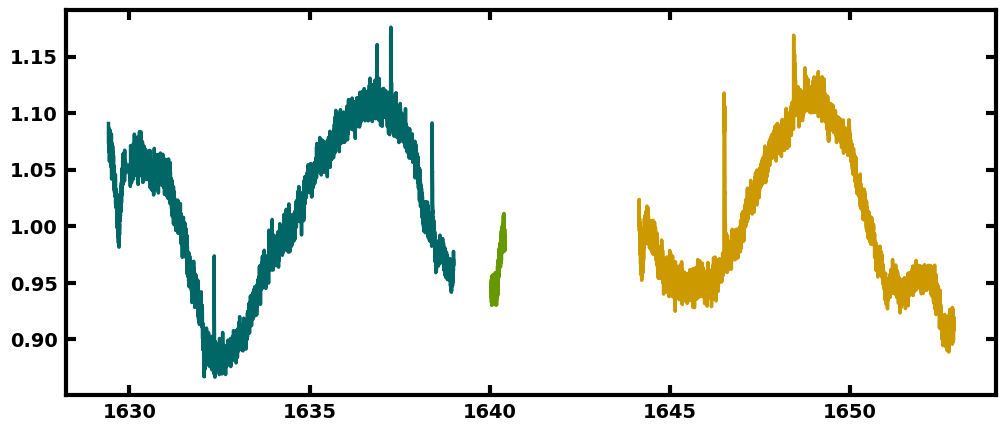

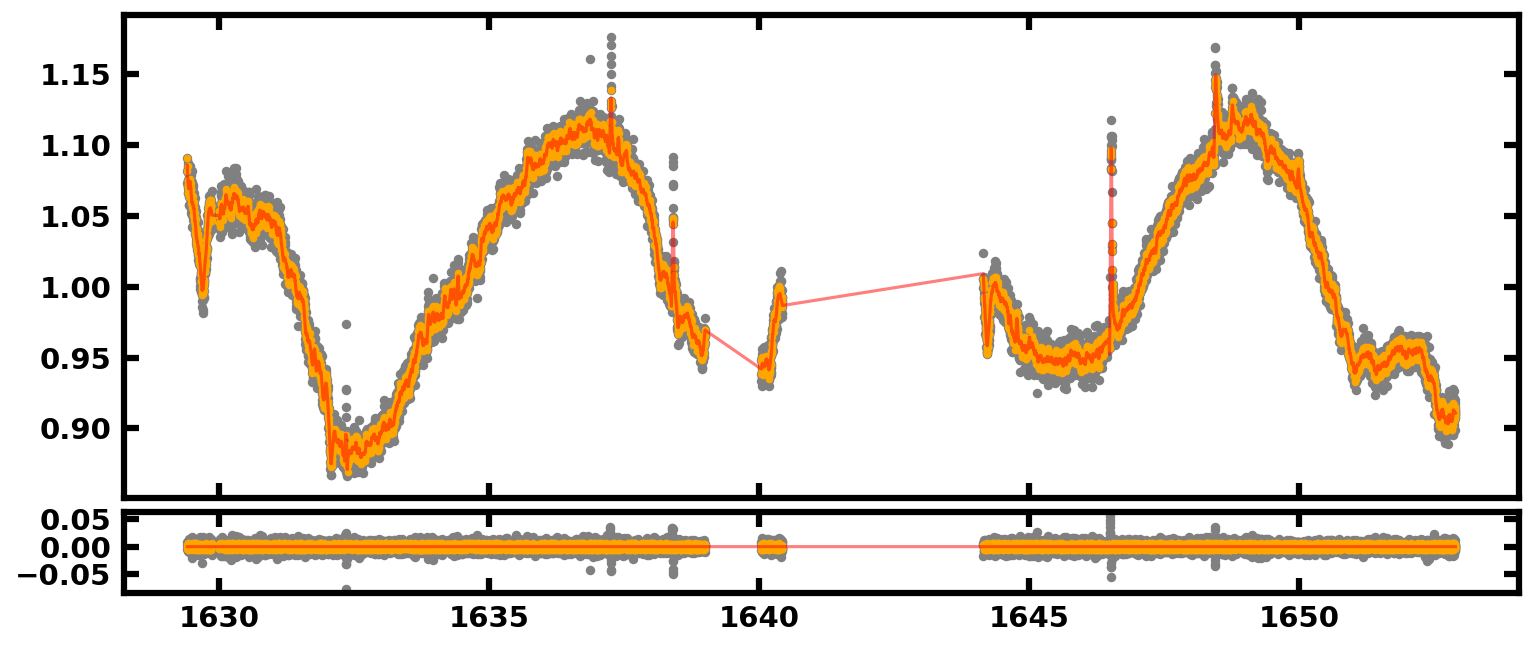

lc: 
<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>
-------
 
1
 
[0, 9412, 9413, 17930]
starts  [0, 9413]
stops  [9412, 17930]
 


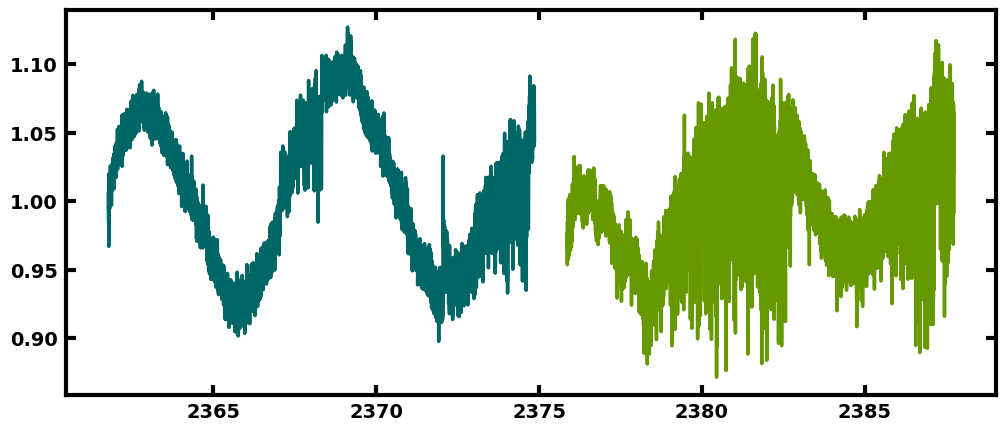

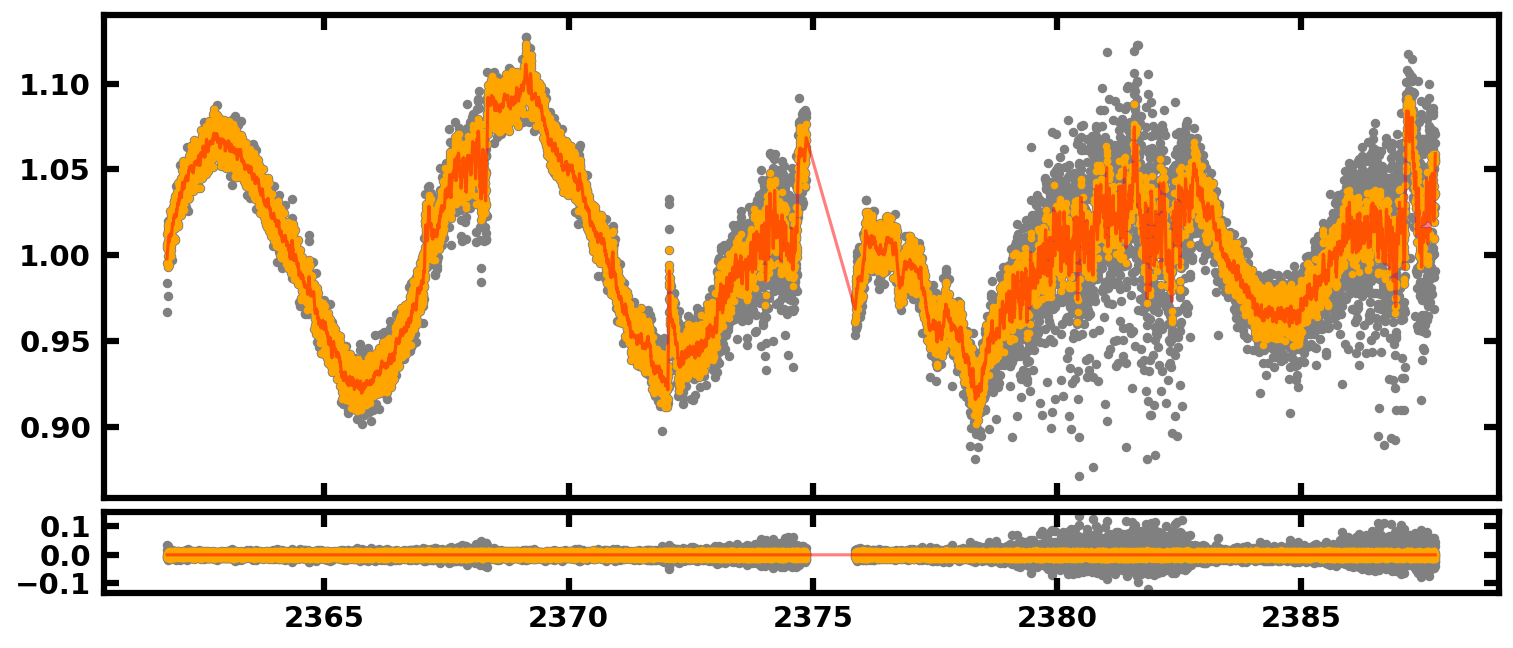

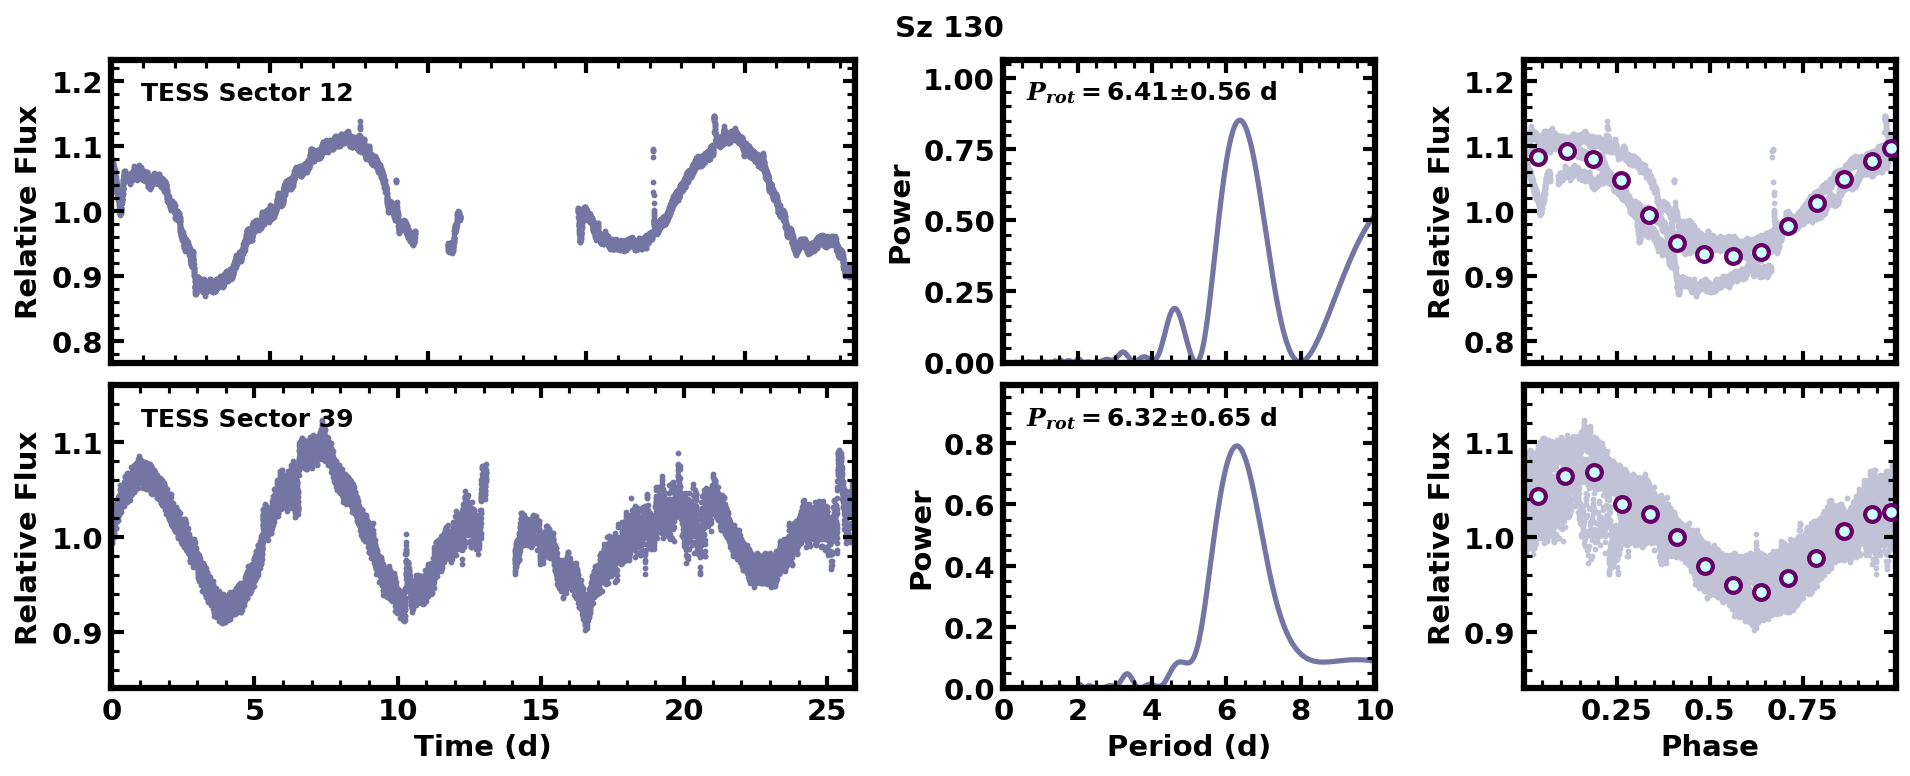

issues:  ['DK Tau', 'HN Tau', 'HV Tau', 'UX Tau', 'UZ Tau', 'V710 Tau']


In [262]:
do_savefig = True

do_final_sample = False # False

do_clean = True

track_completed = False

plot_extras = True

for target_i, target in enumerate(target_list):

    if choose_target != None:
        if target != choose_target:
            continue
        else:
            if try_target_name != None:
                target = try_target_name

    if do_final_sample == True:
        quick_df = raw_df[raw_df['Target'] == target]
        lc_sources = quick_df['LC Source'].values
        per_sources = quick_df['Prot Reference'].values
        where_lc_source = np.where(lc_sources == do_mission)[0]
        where_per_source = np.where(per_sources == 'This Work')[0]

        if len(where_lc_source) == 0:
            in_final_sample = False
        if (len(where_lc_source) > 0) and (len(where_per_source) == 0):
            in_final_sample = False
        elif (len(where_lc_source) > 0) and (len(where_per_source) > 0):
            if where_lc_source[0] not in where_per_source:
                in_final_sample = False
        else:
            in_final_sample = True



    quick_df = raw_df[raw_df['Target'] == target]
    lc_sources = quick_df['LC Source'].values
    per_sources = quick_df['Prot Reference'].values
    where_lc_source = np.where(lc_sources == do_mission)[0]
    where_per_source = np.where(per_sources == 'This Work')[0]

    in_final_sample = True

    if len(where_lc_source) == 0:
        in_final_sample = False
    else:
        if len(where_per_source) == 0:
            in_final_sample = False
        if len(where_per_source) > 0:
            if where_lc_source[0] not in where_per_source:
                in_final_sample = False

    if in_final_sample == True:
        lightcurve_save_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Lightcurves/' + do_mission + '/Final_Sample/'
    if in_final_sample == False:
        lightcurve_save_dir = '/Users/lib278/Documents/Manuscripts/PRIMORDIAL_DISKS/Test_Figures/Lightcurves/' + do_mission + '/Rest_of_Sample/'
    
    if (in_final_sample == False) and (do_final_sample == True):
        continue




    # print('\nGOT HERE!!!!!!!!\n')
            

    if ((target not in completed) and (target not in issues)):  #  or (choose_target != None):
        print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n', target, '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

        if do_mission == 'TESS':
            if target in TESS_SPOC_targets:
                author_name = 'TESS-SPOC'
            elif target in TESS_QLP_targets:
                author_name = 'QLP'
            elif target in TESS_CDIPS_targets:
                author_name = 'CDIPS'
            elif target in TESS_PATHOS_targets:
                author_name = 'PATHOS'
            else:
                author_name = 'SPOC'

        if do_mission == 'K2':
            if target in K2SFF_targets:
                author_name = 'K2SFF'
            elif target in EVEREST_targets:
                author_name = 'EVEREST'
            else:
                author_name = 'K2'


        if (target == 'DR Tau') and (author_name == 'K2'):
            search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
            search_result = search_result[search_result.target_name == 'ktwo246923113']

        elif (author_name == 'K2SFF') or (author_name == 'EVEREST'):
            try:
                search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
            except:
                print('\nIssue getting a K2SFF or EVEREST search_result.\n')
                issues.append(target)
                continue
        elif (author_name == 'SPOC') or (author_name == 'K2'):
            try:
                search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name, exptime=exptime)
            except:
                print('\nIssue getting a SPOC or K2 search_result.\n')
                issues.append(target)
                continue
        elif (author_name == 'TESS-SPOC') or (author_name == 'QLP'):
            try:
                search_result = lk.search_lightcurve(target, mission=mission_name, author=author_name)
            except:
                print('\nIssue getting a TESS-SPOC or QLP search_result.\n')
                issues.append(target)
                continue



        print(search_result)



        if len(search_result) >= 1:
            multiple.append(target)

            lc_time_stitch = []
            lc_flux_stitch = []
            lc_flux_err_stitch = []
            lc_mission_stitch = []
            lc_time_blocks = []
            lc_flux_blocks = []
            lc_flux_err_blocks = []
            lc_mission_blocks = []


            mission_nums = []
            for mission_j in range(len(search_result.mission)):
                if do_mission == 'TESS':
                    mission_num_str = ''
                    for char_j in search_result.mission[mission_j]:
                        if char_j.isnumeric():
                            mission_num_str += str(int(char_j))
                if do_mission == 'K2':
                    mission_num_str = search_result.mission[mission_j].split(' ')[-1]
                if mission_num_str[0] == '0':
                    mission_num_str = mission_num_str[1:]

                mission_nums.append(int(mission_num_str))

            mission_sets = []
            mission_setnums = []
            where_new_mission_set = np.where(np.diff(mission_nums) > 1)[0] + 1
            for mission_k in range(len(mission_nums)):
                if mission_k == 0:
                    m_set = [search_result.mission[mission_k]]
                    m_setnum = [mission_nums[mission_k]]
                    if len(mission_nums) == 1:
                        mission_sets.append(m_set)
                        mission_setnums.append(m_setnum)


                elif mission_k in where_new_mission_set:
                    mission_sets.append(m_set)
                    mission_setnums.append(m_setnum)
                    m_set = [search_result.mission[mission_k]]
                    m_setnum = [mission_nums[mission_k]]

                elif mission_k == len(mission_nums) - 1:
                    m_set.append(search_result.mission[mission_k])
                    m_setnum.append(mission_nums[mission_k])
                    mission_sets.append(m_set)
                    mission_setnums.append(m_setnum)
                    
                else:
                    m_set.append(search_result.mission[mission_k])
                    m_setnum.append(mission_nums[mission_k])

            if do_mission == 'TESS':
                if target == 'V1094 Sco':
                    mission_sets = [['TESS Sector 39'], ['TESS Sector 65']]
                    mission_setnums = [['39'], ['65']]

                if target == 'RY Lup':
                    mission_sets = [['TESS Sector 12']]
                    mission_setnums = [['12']]

                if target == 'DR Tau':
                    mission_sets = [['TESS Sector 43', 'TESS Sector 44'], ['TESS Sector 70']]
                    mission_setnums = [['43', '44'], ['71']]

                if target == 'V409 Tau':
                    mission_sets = [['TESS Sector 43'], ['TESS Sector 44']]
                    mission_setnums = [['43'], ['44']]

                if target == 'SY Cha':
                    mission_sets = [['TESS Sector 11'], ['TESS Sector 12']]
                    mission_setnums = [['11'], ['12']]
                
                # if target == 'TW Hya':
                #     mission_sets = [['TESS Sector 9'], ['TESS Sector 63']]
                #     mission_setnums = [['9'], ['63']]

            if do_mission == 'K2':
                if target == 'HD 143006':
                    mission_sets = [['K2 Campaign 02'], ['K2 Campaign 15']]
                    mission_setnums = [['02'], ['15']]




            print('Mission Sets: ', mission_sets)
            print('Mission Setnums: ', mission_setnums)

            
            lc_time_sets = []
            lc_flux_sets = []
            lc_flux_err_sets = []
            lc_mission_set_strs = []
            for mission_set_i, mission_set in enumerate(mission_sets):
                lc_time_set = []
                lc_flux_set = []
                lc_flux_err_set = []
                lc_mission_setnums = ''
                for mission_i, mission in enumerate(mission_set):




                    if target == 'DR Tau':
                        search_mission = search_result[search_result.mission == mission][0]
                    elif (target == 'HD 143006') and (mission == 'K2 Campaign 02'):
                        search_mission = search_result[search_result.mission == mission][0]
                    else:
                        search_mission = search_result[search_result.mission == mission]



                    # --------------- DOWNLOAD LIGHTCURVE ---------------- # 
                    try:
                        lc = search_mission.download()
                    except:
                        print('\nIssue dowloading target lightcurve.\n')
                        # issues.append(target)
                        # continue

                    print('lc: ')
                    # print(lc)
                    print(lc.columns)
                    print('-------')

                    time_download = lc.time
                    if author_name == 'QLP':
                        try:
                            pdcsap_flux_download = lc.flux
                        except:
                            print('\nIssue reading QLP flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.flux_err
                    elif author_name == 'K2SFF':
                        try:
                            pdcsap_flux_download = lc.flux
                        except:
                            print('\nIssue reading K2SFF flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.flux_err
                    elif author_name == 'CDIPS':
                        try:
                            pdcsap_flux_download = lc.flux
                        except:
                            print('\nIssue reading CDIPS flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.flux_err
                    elif author_name == 'PATHOS':
                        try:
                            pdcsap_flux_download = lc.flux
                        except:
                            print('\nIssue reading PATHOS flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.flux_err
                    elif author_name == 'EVEREST':
                        try:
                            pdcsap_flux_download = lc.fcor
                        except:
                            print('\nIssue reading EVEREST flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.flux_err
                    else:
                        try:
                            pdcsap_flux_download = lc.pdcsap_flux
                        except:
                            print('\nIssue reading pdcsap_flux of target.\n')
                            issues.append(target)
                            continue
                        pdcsap_flux_err_download = lc.pdcsap_flux_err

                    lc_time = time_download.value[np.isnan(pdcsap_flux_download.value) == False]
                    lc_flux = pdcsap_flux_download.value[np.isnan(pdcsap_flux_download.value) == False]
                    lc_flux_err = pdcsap_flux_err_download.value[np.isnan(pdcsap_flux_download.value) == False]

                    # print(lc_time, '\n', lc_flux, '\n', lc_flux_err, '\n')

                    nan_err_targs = ['V1094 Sco', 'DR Tau', 'RY Tau', '2MASS J04322210+1827426', 'AA Tau', '2MASS J11120327-7637034', '2MASS J16000236-4222145', 'V409 Tau']

                    if target in nan_err_targs:
                        lc_flux_err = [1e-6]*len(lc_time)
                    
                    if mission == 'K2 Campaign 02':
                        lc_flux = lc_flux[(lc_time >= lc_time[0] + 10) & (lc_time <= lc_time[0] + 42)]
                        lc_flux_err = lc_flux_err[(lc_time >= lc_time[0] + 10) & (lc_time <= lc_time[0] + 42)]
                        lc_time = lc_time[(lc_time >= lc_time[0] + 10) & (lc_time <= lc_time[0] + 42)]

                    lc_flux /= np.median(lc_flux)
                    lc_flux_err /= np.median(lc_flux)

                    lc_time_set = np.array(np.concatenate((lc_time_set, lc_time)))
                    lc_flux_set = np.array(np.concatenate((lc_flux_set, lc_flux)))
                    lc_flux_err_set = np.array(np.concatenate((lc_flux_err_set, lc_flux_err)))
                    if mission_i == 0:
                        lc_mission_setnums += str(mission_setnums[mission_set_i][mission_i])
                    elif mission_i > 0:
                        lc_mission_setnums += ' & ' + str(mission_setnums[mission_set_i][mission_i])


                if target == '2MASS J11120327-7637034':
                    lc_time_set = lc_time_set[int(0.8*len(lc_flux_set)): -1]
                    lc_flux_set = lc_flux_set[int(0.8*len(lc_flux_set)): -1]
                    lc_flux_err_set = lc_flux_err_set[int(0.8*len(lc_flux_set)): -1]
                # if target == '2MASS J16000236-4222145':
                #     lc_time_set = lc_time_set[int(0.6*len(lc_flux_set)): -1]
                #     lc_flux_set = lc_flux_set[int(0.6*len(lc_flux_set)): -1]
                #     lc_flux_err_set = lc_flux_err_set[int(0.6*len(lc_flux_set)): -1]

                clean_time, clean_flux, clean_flux_err = clean_lightcurve(xdata=lc_time_set, ydata=lc_flux_set, ydata_err=lc_flux_err_set, itime=exptime, which_target=target, which_telescope=do_mission, do_clean=do_clean, do_plot=plot_extras)

                lc_time_sets.append(clean_time)
                lc_flux_sets.append(clean_flux)
                lc_flux_err_sets.append(clean_flux_err)
                lc_mission_set_strs.append(lc_mission_setnums)



            plot_publication_lightcurve(target=target, lcv_x_sets=lc_time_sets, lcv_y_sets=lc_flux_sets, lcv_y_err_sets=lc_flux_err_sets, lc_mission_nums=lc_mission_set_strs, mission_str=do_mission, lightcurve_save_dir=lightcurve_save_dir, savefig=do_savefig)


        if track_completed == True:
            completed.append(target)

print('issues: ', issues)

In [243]:
# import lightkurve as lk
# # ---------------------------------------------------------------------------------------------- #
# # DISPLAY THE FULL LIGHTKURVE SEARCH RESULT FOR A SPECIFIC TARGET TO VISUALIZE WHICH DATA
# # PRODUCTS ARE AVAILABLE FOR THAT TARGET. 
# # ---------------------------------------------------------------------------------------------- #

# # ----------- SPECIFY TARGET AND MISSION ----------- #
# choose_target = 'LkCa 15'
# choose_mission = 'TESS'

# # ----------- GENERATE AND DISPLAY SEARCH RESULT ----------- #
# search_result = lk.search_lightcurve(choose_target, mission=choose_mission)
# print(search_result, '\n')

# # ---------------------------------------------------------------------------------------------- #
# # MANY AUTHORS ARE ASSOCIATED WITH MULTIPLE MISSIONS ("SECTORS" FOR TESS, "CAMPAIGNS" FOR K2), 
# # TO DOWNLOAD A LIGHTCURVE FOR A SPECIFIC AUTHOR AND MISSION, DEFINE THOSE VARIABLES AND TRUNCATE
# # THE SEARCH RESULTS TABLE SO THAT IT INCLUDES ONLY THAT AUTHOR AND MISSION YOU ARE INTERESTED
# # IN. EXAMPLE BELOW:
# # ---------------------------------------------------------------------------------------------- #

# # ----------- SPECIFY AUTHOR AND MISSION ----------- #
# choose_author = 'SPOC'
# choose_mission = 'TESS Sector 44'

# # ----------- TRUNCATE THE SEARCH RESULT FOR SPECIFIC AUTHOR TO INCLUDE ONLY THE MISSION YOU ARE INTERESTED IN ----------- #
# search_result_for_specific_author_and_mission = search_result[(search_result.mission == choose_mission) & (search_result.author == choose_author)][0]

# # ----------- PRINT TRUNCATED SEARCH RESULTS TABLE TO VERIFY THAT THE CORRECT INFORMATION WAS SPECIFIED ----------- #
# print(search_result_for_specific_author_and_mission, '\n')

# # ----------- DOWNLOAD THE LIGHTCURVE ASSOCIATED WITH YOUR TRUNCATED SEARCH RESULTS TABLE ----------- #
# lc_for_specific_author_and_mission = search_result_for_specific_author_and_mission.download()

# # ---------------------------------------------------------------------------------------------- #
# # THE LIGHTCURVE OBJECT CAN BE THOUGHT OF AS A TABLE TOO, AND THE CONTENT OF THE LIGHTCURVE OBJECT
# # CAN VARY FROM AUTHOR TO AUTHOR. PRINT THE LIGHTCURVE OBJECT'S COLUMNS TO GAIN A CLEARER SENSE
# # FOR THE EXACT DATA PRODUCTS DIFFERENT AUTHORS' LIGHTCURVE OBJECTS CONTAIN.
# # ---------------------------------------------------------------------------------------------- #

# # ----------- DISPLAY COLUMNS IN LIGHTCURVE OBJECT ----------- #
# print(lc_for_specific_author_and_mission.columns, '\n')